Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

path = r"C:\Users\Surface\Masterarbeit\data\Baseline.xlsx"

df = pd.read_excel(path)


Transformation Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# get the numerical features
data_num = df.drop('x_Einzug [mm]', axis = 1)
# get the target values
data_labels = df['x_Einzug [mm]'].to_numpy()

# pipeline for preprocessing the data

# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

data_prep = data_pipeline.fit_transform(data_num)

X_train, X_test, y_train, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)


Training NN with MC Dropout for Uncertainty quantification

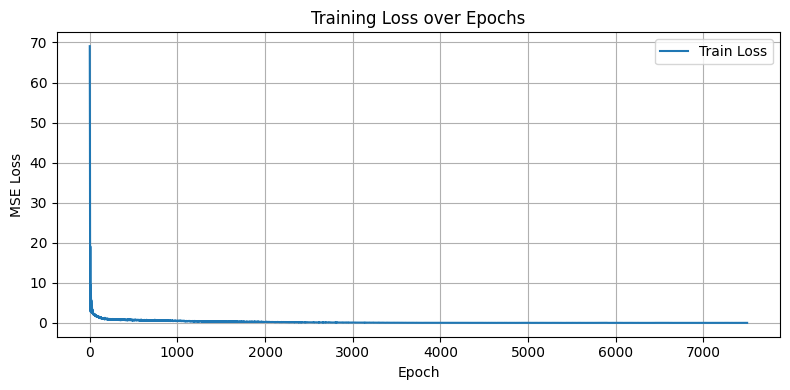

[69.06822967529297, 59.57659149169922, 46.12558364868164, 25.294904708862305, 5.913820743560791, 12.550741195678711, 19.124195098876953, 9.379118919372559, 2.850659132003784, 4.185910701751709, 7.145817756652832, 9.501241683959961, 9.391302108764648, 7.395617485046387, 5.412455081939697, 3.077279806137085, 2.8438093662261963, 5.00978946685791, 5.683470249176025, 5.67865514755249, 3.3506581783294678, 2.673649549484253, 2.722430944442749, 3.0842483043670654, 3.6407833099365234, 4.042726039886475, 3.702826499938965, 3.094217300415039, 2.469402313232422, 2.407623052597046, 2.6185898780822754, 2.9241321086883545, 3.337834596633911, 2.6958987712860107, 2.6069412231445312, 2.4375956058502197, 2.409168004989624, 2.3456411361694336, 2.563943386077881, 2.4495136737823486, 2.106905460357666, 2.098184585571289, 2.1849825382232666, 2.17390513420105, 2.11527943611145, 2.1616098880767822, 2.2391536235809326, 2.017972946166992, 2.167325258255005, 2.064882755279541, 2.1234140396118164, 2.14112710952758

In [15]:
import torch
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import r2_score

# Convert training and testing data to PyTorch tensors
X_tr = torch.from_numpy(X_train).float()
X_te = torch.from_numpy(X_test).float()
y_tr = torch.from_numpy(y_train).float().unsqueeze(1)  # Add extra dimension for compatibility
y_te = torch.from_numpy(y_test).float().unsqueeze(1)


# Define a fully connected neural network with ReLU activations and Dropout
dp = 0.2
model = torch.nn.Sequential(
    torch.nn.Linear(6, 64),     # Input layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 128),   # Hidden layer -> 128 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(128, 64),   # Hidden layer -> 64 neurons
    torch.nn.ReLU(),
    torch.nn.Dropout(p = dp),   # Dropout Layer with 5% Neurons set to 0
    torch.nn.Linear(64, 1)      # Output layer -> 1 value (regression)
)

# Define Mean Squared Error loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Set learning rate and optimizer
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr)

# Track loss history during training
loss_history = []

# Set model to training mode
model.train()
for i in range(8000):
    optimizer.zero_grad()               # Reset gradients
    y_pred = model(X_tr)                # Forward pass
    loss = loss_fn(y_pred, y_tr)        # Compute MSE loss
    loss.backward()                     # Backpropagation
    optimizer.step()                    # Update weights
    loss_history.append(loss.item())    # Save loss value

    # Update plot every 50 epochs
    if i % 500 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(loss_history, label='Train Loss', color='tab:blue')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
print(loss_history)

Plot the uncertainty interval for the NN with MC Dropout


R² Train: 0.9936 | R² Test: 0.9941


,True value,Prediction,Difference
0,6.590000,6.664107,-0.074107
1,8.100000,8.106243,-0.006243
2,9.231000,9.111594,0.119406
3,7.623000,7.585620,0.037380
4,9.253500,9.145931,0.107569
5,10.484500,10.310979,0.173521
6,8.219000,8.212820,0.006180
7,6.679500,6.741607,-0.062107
8,8.614500,8.552622,0.061878
9,7.534500,7.565889,-0.031389


Coverage: 100.00%


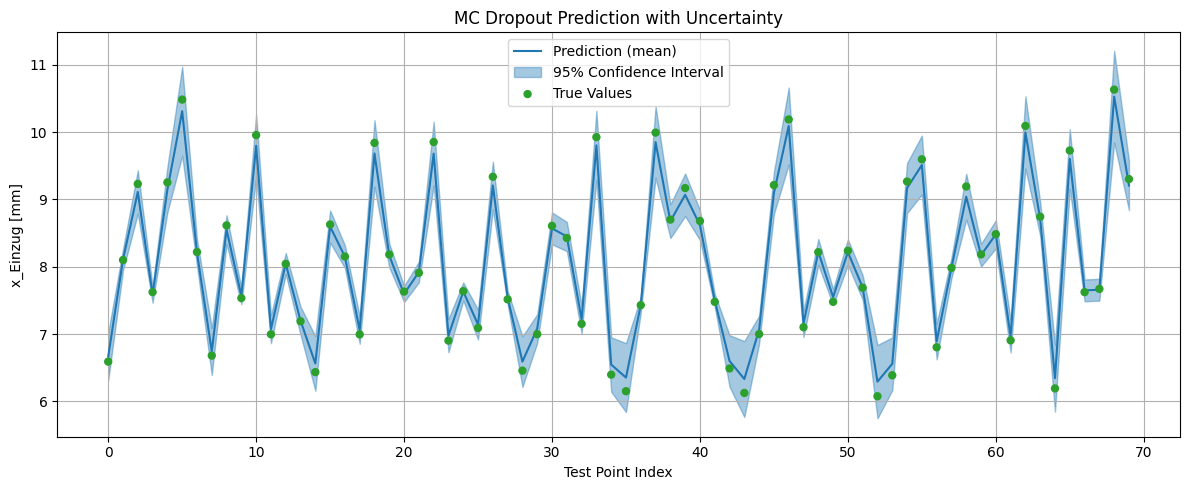

In [ ]:
# Keep the model in training mode to keep dropout active
model.train()
#print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)

# Make multiple stochastic predictions (MC Dropout)
n_samples = 500
y_train_pred = torch.stack([model(X_tr) for i in range(n_samples)]).detach().numpy() #list comprehension for the number of stochastic forward passes for MC Dropout
y_test_pred = torch.stack([model(X_te) for i in range(n_samples)]).detach().numpy()
#print(y_train_pred.shape, y_test_pred.shape)

# Calculate the mean and standard deviation of the predictions on the train data
y_train_pred_mean = y_train_pred.mean(axis = 0)
y_train_Pred_std = y_train_pred.std(axis = 0)
#print(y_train_pred_mean.shape, y_train_Pred_std.shape)

# Calculate the mean and standard deviation of the predictions on the test data
y_test_pred_mean = y_test_pred.mean(axis = 0)
y_test_pred_std = y_test_pred.std(axis = 0)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred_mean)
r2_test = r2_score(y_te, y_test_pred_mean)

# Create comparison DataFrame
vergleich_df = pd.DataFrame({
    'True value': y_test[:10],
    'Prediction': y_test_pred_mean[:10].flatten(),
    'Difference': y_test[:10] - y_test_pred_mean[:10].flatten()
})

# Print performance
print(f'\nR² Train: {r2_train:.4f} | R² Test: {r2_test:.4f}')

# Display predictions with color-coded differences
display(vergleich_df.style.background_gradient(cmap='RdYlGn_r'))

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = y_test_pred_mean.flatten()  # Predicted mean for each test point
mc_std = y_test_pred_std.flatten()    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = mc_mean - 2 * mc_std
mc_upper_bound = mc_mean + 2 * mc_std

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(len(y_te[:70]))  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[:70], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[:70], mc_upper_bound[:70], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_te[0:70].flatten(), label="True Values", c=colors[:70], s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()